In [1]:
import sys
import os
import cv2
import time
import numpy as np
import ffmpeg
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision.transforms import ToPILImage

In [2]:
if os.name == 'nt':
    repo_path = Path(".").absolute().parent
    data_path = Path("D:/Datas/") / "lanevideo"
else:    
    repo_path = Path(".").absolute().parent
    data_path = repo_path.parent / "data" / "lanevideo"
    
sys.path.append(str(repo_path))

---

* References: https://medium.com/@mithi/advanced-lane-finding-using-computer-vision-techniques-7f3230b6c6f2

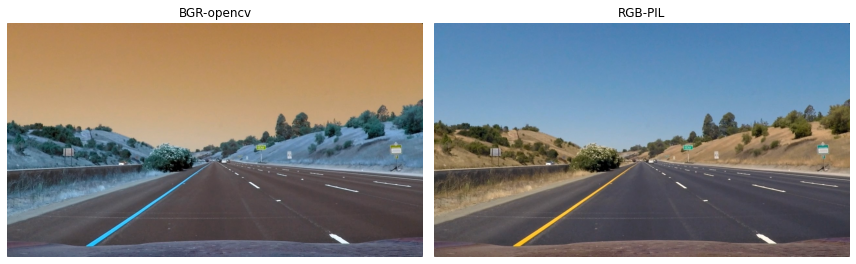

In [3]:
from lanedetection.helpers import imreader, imsaver
img_path = "./imgs/test.png"
img_path = "./imgs/straight_lines.jpg"
image = imreader(img_path)
height, width = 480, 640

def correct_rgb(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

def resize_image(img, width, height):
    return cv2.resize(img, (width, height))

def draw(img1, img2, tit1, tit2, cmap1=None, cmap2="gray"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axes
    ax1.imshow(img1, cmap=cmap1)
    ax1.set_title(tit1)
    ax1.set_axis_off()

    ax2.imshow(img2, cmap=cmap2)
    ax2.set_title(tit2)
    ax2.set_axis_off()
    plt.tight_layout()
    plt.show()

# img = resize_image(image, width, height)
# Stay alert when using OpenCV, they use BGR format instead of RGB
img = image
img_BGR = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
draw(img_BGR, image, "BGR-opencv", "RGB-PIL", cmap1=None, cmap2=None)

1. Camera calibration

In [4]:
from lanedetection import ChessBoard

# Let's initialize 20 chessboards, note that at instatiation, 
# it finds all chessboard corners and object points
chessboards = []

for n in range(20):
    this_path = f"./camera_cal/calibration{n+1}.jpg"
    chessboard = ChessBoard(i = n, path = this_path, nx = 9, ny = 6)
    chessboards.append(chessboard)

# We use these corners and object points (and image dimensions) 
# from all chessboards to estimate the calibration parameters 
points, corners, shape = [], [], chessboards[0].dimensions

for chessboard in chessboards:    
    if chessboard.has_corners: 
        points.append(chessboard.object_points)
        corners.append(chessboard.corners)

r, matrix, distortion_coef, rv, tv = cv2.calibrateCamera(points, corners, shape, None, None)

# Let's store these parameters somewhere so we can use them later
calibration_data = { "camera_matrix": matrix, "distortion_coefficient": distortion_coef }


In [5]:
import pickle

pickle.dump(calibration_data, open( "calibration_data.p", "wb" ))

2. perspective transformation

In [6]:
from lanedetection import BirdsEye, LaneFilter, Curves, show_images, save_image, roi

In [7]:
calibration_data = pickle.load(open("calibration_data.p", "rb" ))

matrix = calibration_data['camera_matrix']
dist_coef = calibration_data['distortion_coefficient']

# src_ratio = [(0.43, 0.64), (0.12, 1.0), (0.87, 1.0), (0.55, 0.64)]
# dest_ratio = [(0.25, 0.0), (0.25, 1.0), (0.75, 1.0), (0.75, 0.0)]

# for test.png
# src_ratio = [(0.26, 0.45), (0.0, 0.65), (0.67, 1.0), (0.60, 0.45)]
# dest_ratio = [(0.25, 0.0), (0.25, 1.0), (0.75, 1.0), (0.75, 0.0)]

# def get_points(ratios, width, height):
#     apply_ratio = lambda x, w, h: (int(w*x[0]), int(h*x[1]))
#     return [apply_ratio(ratio, w=width, h=height) for ratio in ratios]

# source_points = get_points(src_ratio, width, height)
# dest_points = get_points(dest_ratio, width, height)

source_points = [(580, 460), (205, 720), (1110, 720), (703, 460)]
dest_points = [(320, 0), (320, 720), (960, 720), (960, 0)]

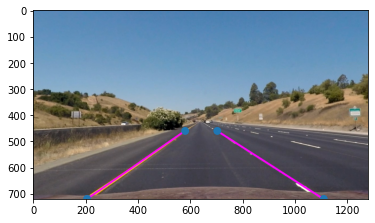

In [8]:
birdsEye = BirdsEye(source_points, dest_points, matrix, dist_coef)
undistorted_img = birdsEye.undistort(img, show_dotted=True)

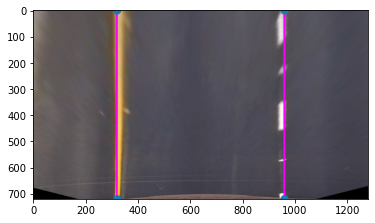

In [9]:
bird_img = birdsEye.sky_view(undistorted_img, show_dotted = True)

In [10]:
p = { 'sat_thresh': 120, 'light_thresh': 40, 'light_thresh_agr': 205,
      'grad_thresh': (0.7, 1.4), 'mag_thresh': 40, 'x_thresh': 20 }

birdsEye = BirdsEye(source_points, dest_points, matrix, dist_coef)
laneFilter = LaneFilter(p)

HSL and HSV format

https://en.wikipedia.org/wiki/HSL_and_HSV

HSL and HSV are both cylindrical geometries, with hue, their angular dimension, starting at the red primary at 0°, passing through the green primary at 120° and the blue primary at 240°, and then wrapping back to red at 360°. In each geometry, the central vertical axis comprises the neutral, achromatic, or gray colors ranging, from top to bottom, white at lightness 1 (value 1) to black at lightness 0 (value 0).

| HSL formatted color| HSV formatted color |
|:---:|:---:|
| <img src="./imgs/HSL.png" >| <img src="./imgs/HSV.png" >|



The **Hue** value is its perceived color number representation based on combinations of red, green and blue. The **Saturation** value is the measure of how colorful or how dull it is. **Lightness** is how closer to white the color is. The yellow lanes are nicely singled out by a combination of lightness and saturation above a certain value. The white lanes are singled out by having a really high lightness value regardless of the saturation and hue.


In case of 8-bit and 16-bit images, R, G, and B are converted to the floating-point format and scaled to fit the 0 to 1 range.

$$\begin{aligned} 
V_{max} & \leftarrow \max(R, G, B) \\
V_{min} & \leftarrow \min(R, G, B) \\
L & \leftarrow \dfrac{V_{max} + V_{min}}{2} \\
S & \leftarrow 
\begin{cases}
\dfrac{V_{max} - V_{min}}{V_{max} + V_{min}} &\quad \text{if } L < 0.5 \\
\dfrac{V_{max} - V_{min}}{2-(V_{max} + V_{min})} &\quad \text{if } L \geq 0.5 \\ 
\end{cases} \\
H & \leftarrow 
\begin{cases}
60 (G-B)/S &\quad \text{if } V_{max} = R \\
120 + 60 (B-R)/S &\quad \text{if } V_{max} = G \\
240 + 60 (R-G)/S &\quad \text{if } V_{max} = B 
\end{cases} \\
\end{aligned}$$

If $H<0$ then $H \leftarrow H+360$. On output $0 \leq L \leq 1, 0 \leq S \leq 1, 0 \leq H \leq 360$. 

For 8-bit image, $V \leftarrow 255 \cdot V, S \leftarrow 255 \cdot S, H \leftarrow H/2$. So, the max values are  

- H: (0, 179)
- L: (0, 255)
- S: (0, 255)

[OpenCV References](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html?#cvtcolor)


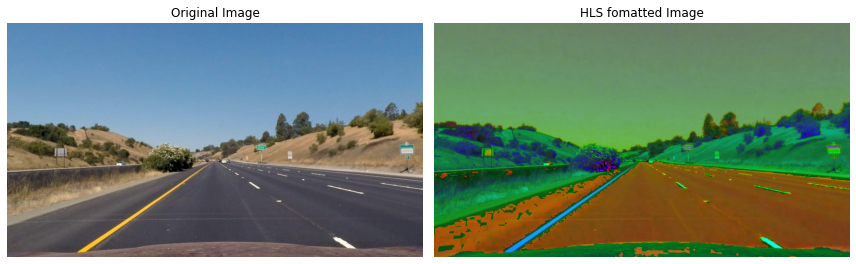

[179, 254, 255]


In [26]:
hls = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS)
draw(undistorted_img, hls, "Original Image", "HLS fomatted Image", cmap1=None, cmap2=None)
print([hls[:, :, i].max() for i in range(3)])

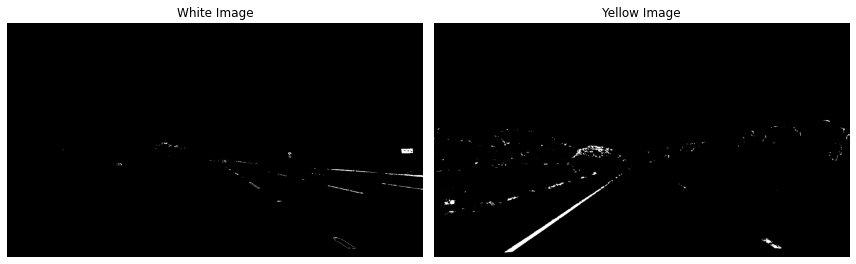

In [153]:
# White-ish areas in image
# H value can be arbitrary, thus within [0 ... 360] (OpenCV: [0 ... 180])
# L value must be relatively high (we want high brightness), e.g. within [0.7 ... 1.0] (OpenCV: [0 ... 255])
# S value must be relatively low (we want low saturation), e.g. within [0.0 ... 0.3] (OpenCV: [0 ... 255])
white_lower_hsl = np.array([np.round(  0 / 2), np.round(0.75 * 255), np.round(0.00 * 255)])
white_upper_hsl = np.array([np.round(360 / 2), np.round(1.00 * 255), np.round(0.30 * 255)])
white_mask_hsl = cv2.inRange(hls, white_lower_hsl, white_upper_hsl)

# Yellow-ish areas in image
# H value must be appropriate (see HSL color space), e.g. within [40 ... 60]
# L value can be arbitrary (we want everything between bright and dark yellow), e.g. within [0.0 ... 1.0]
# S value must be above some threshold (we want at least some saturation), e.g. within [0.35 ... 1.0]
yellow_lower_hsl = np.array([np.round( 40 / 2), np.round(0.47 * 255), np.round(0.16 * 255)])
yellow_upper_hsl = np.array([np.round( 60 / 2), np.round(1.00 * 255), np.round(1.00 * 255)])
yellow_mask_hsl = cv2.inRange(hls, yellow_lower_hsl, yellow_upper_hsl)

draw(white_mask_hsl, yellow_mask_hsl, "White Image", "Yellow Image", cmap1="gray", cmap2="gray")

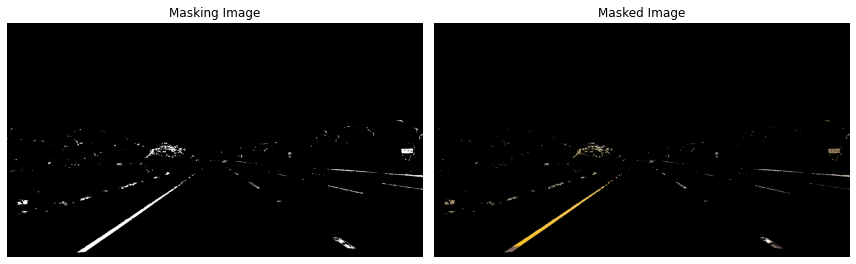

In [154]:
# Calculate combined mask, and masked image
mask_hsl = cv2.bitwise_or(yellow_mask_hsl, white_mask_hsl)
masked_hsl = cv2.bitwise_and(img, img, mask = mask_hsl)
draw(mask_hsl, masked_hsl, "Masking Image", "Masked Image", cmap1="gray", cmap2=None)

other way to do

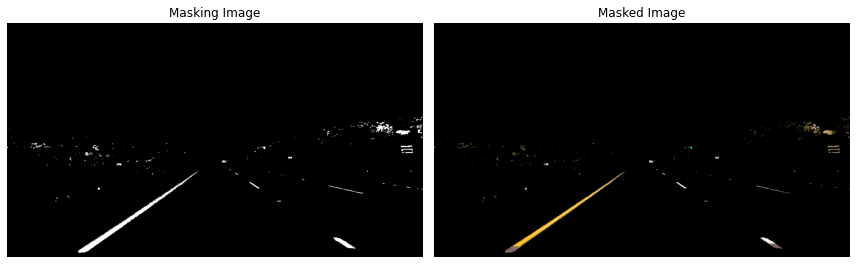

In [155]:
sat_thresh = 120
light_thresh = 40
light_thresh_agr = 205

l = hls[:, :, 1]
s = hls[:, :, 2]
z = np.zeros_like(s)

color_cond1 = (s > sat_thresh) & (l > light_thresh)
color_cond2 = l > light_thresh_agr
mask_hsl2 = z.copy()
mask_hsl2[(color_cond1 | color_cond2)] = 1*255
masked_hsl2 = cv2.bitwise_and(img, img, mask = mask_hsl2)

draw(mask_hsl2, masked_hsl2, "Masking Image", "Masked Image", cmap1="gray", cmap2=None)

hsv formatted

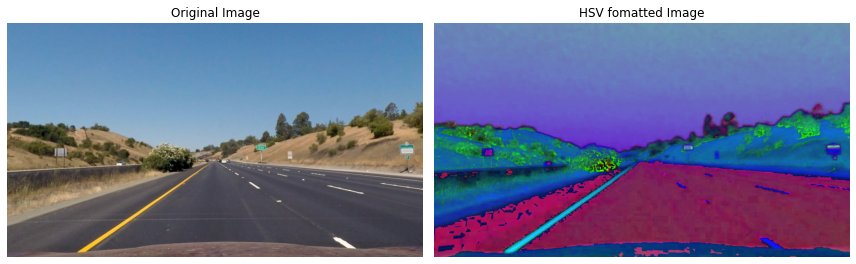

[179, 255, 255]


In [156]:
hsv = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HSV)
draw(undistorted_img, hsv, "Original Image", "HSV fomatted Image", cmap1=None, cmap2=None)
print([hsv[:, :, i].max() for i in range(3)])

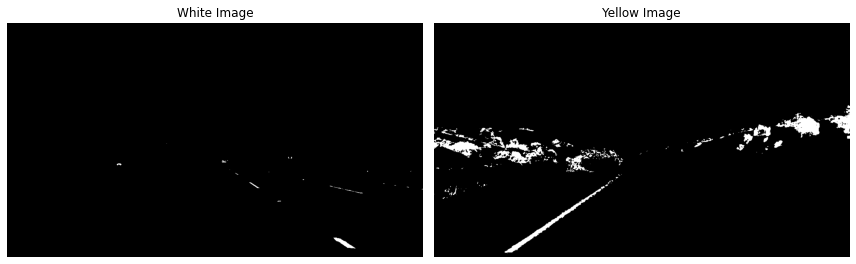

In [157]:
# White-ish areas in image
white_lower_hsv = np.array([np.round(  0 / 2), np.round(0.00 * 255), np.round(0.90 * 255)])
white_upper_hsv = np.array([np.round(360 / 2), np.round(0.20 * 255), np.round(1.00 * 255)])
# white_lower_hsv = np.array([0, 0, 229])
# white_upper_hsv = np.array([180, 38, 255])
white_mask_hsv = cv2.inRange(hsv, white_lower_hsv, white_upper_hsv)

# Yellow-ish areas in image
yellow_lower_hsv = np.array([np.round( 40 / 2), np.round(0.47 * 255), np.round(0.16 * 255)])
yellow_upper_hsv = np.array([np.round( 60 / 2), np.round(1.00 * 255), np.round(1.00 * 255)])
# yellow_lower_hsv = np.array([21, 39, 64])
# yellow_upper_hsv = np.array([40, 255, 255])
yellow_mask_hsv = cv2.inRange(hsv, yellow_lower_hsv, yellow_upper_hsv)

draw(white_mask_hsv, yellow_mask_hsv, "White Image", "Yellow Image", cmap1="gray", cmap2="gray")

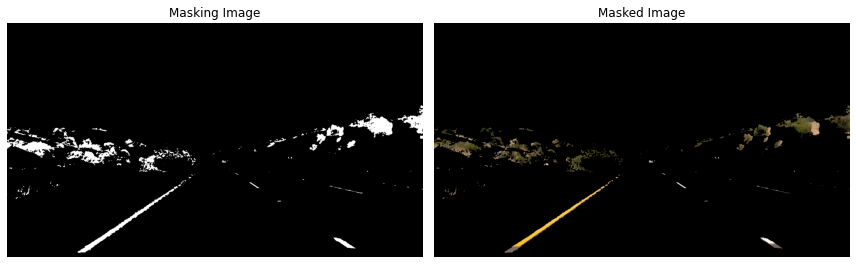

In [158]:
# Calculate combined mask, and masked image
mask_hsv = cv2.bitwise_or(yellow_mask_hsv, white_mask_hsv)
masked_hsv = cv2.bitwise_and(img, img, mask=mask_hsv)
draw(mask_hsv, masked_hsv, "Masking Image", "Masked Image", cmap1="gray", cmap2=None)

Sobel Filter

As an added precaution, because we might see some yellow and while lines that are not lanes, or there might be lanes which are not that distinctly yellow and white, we use what is called a **Sobel operator**. A Sobel operator essentially measures the rate of change in value (and its direction) between two locations of the image. This is also technically called as the derivative or gradient.

https://en.wikipedia.org/wiki/Sobel_operator

[OpenCV References](https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html?highlight=sobel#cv.Sobel)

In [159]:
from lanedetection import scale_abs

l = hls[:, :, 1]
s = hls[:, :, 2]
z = np.zeros_like(s)

grad_min, grad_max = (0.7, 1.4)  # grad_thresh
mag_thresh = 40
x_thresh = 20

In [160]:
lx = cv2.Sobel(l, cv2.CV_64F, 1, 0, ksize = 5)
ly = cv2.Sobel(l, cv2.CV_64F, 0, 1, ksize = 5)
gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
l_mag = np.sqrt(lx**2 + ly**2)
slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
mask_sobel = z.copy()
sobel_cond1 = slm > mag_thresh
sobel_cond2 = slx > x_thresh
sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
mask_sobel[(sobel_cond1 & sobel_cond2 & sobel_cond3)] = 1*255

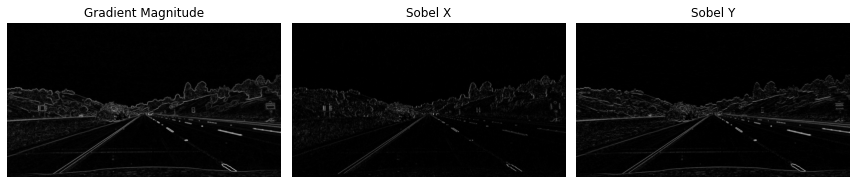

In [161]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
for ax, pic, tit in zip(axes, [slm, slx, sly], ["Gradient Magnitude", "Sobel X", "Sobel Y"]):
    ax.imshow(pic, cmap="gray")
    ax.set_axis_off()
    ax.set_title(tit)
    
plt.tight_layout()
plt.show()

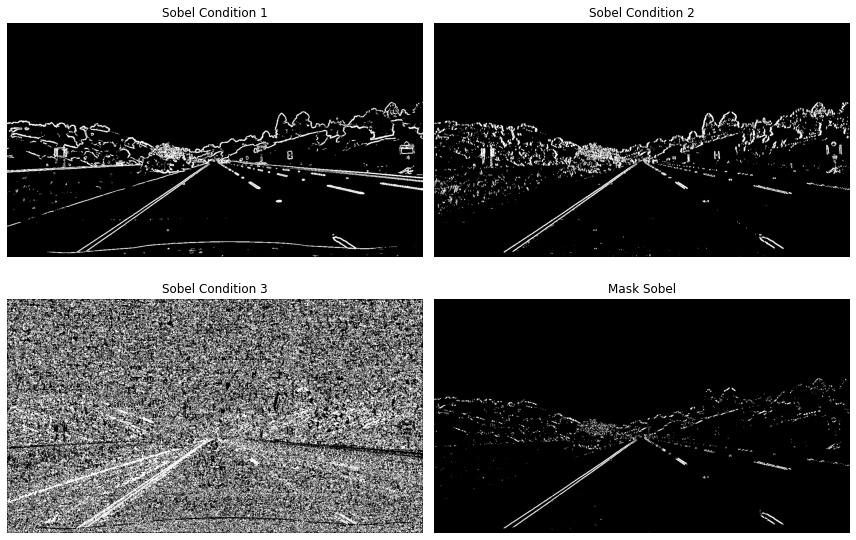

In [162]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, pic, tit in zip(axes.flatten(), 
                   [sobel_cond1, sobel_cond2, sobel_cond3, mask_sobel],
                   ["Sobel Condition 1", "Sobel Condition 2", "Sobel Condition 3", "Mask Sobel"]):
    ax.imshow(pic, cmap="gray")
    ax.set_axis_off()
    ax.set_title(tit)
    
plt.tight_layout()
plt.show()

combination of Color Filter and Sobel Filter

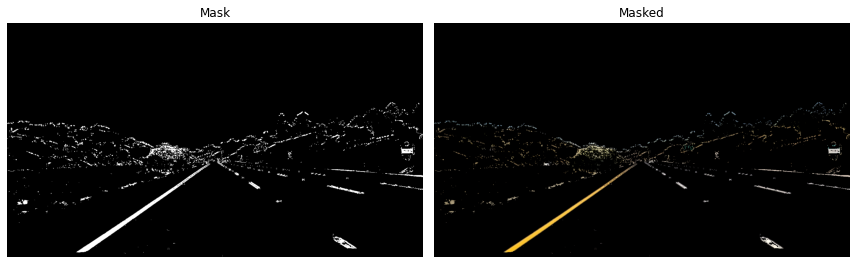

(720, 1280) (720, 1280, 3)


In [163]:
mask = cv2.bitwise_or(mask_hsl, mask_sobel)
masked_img = cv2.bitwise_and(undistorted_img, undistorted_img, mask=mask)
draw(mask, masked_img, "Mask", "Masked", cmap1="gray", cmap2=None)
print(mask.shape, masked_img.shape)

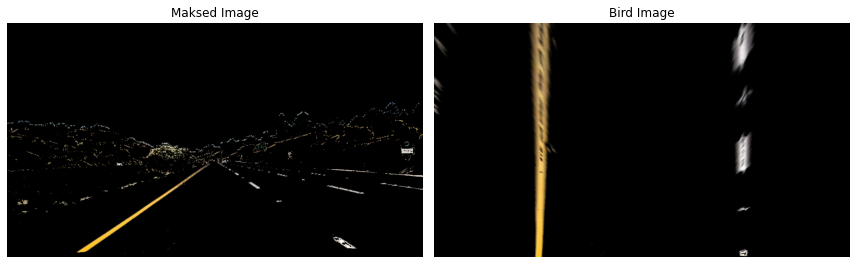

In [164]:
bird_img = birdsEye.sky_view(masked_img)
draw(masked_img, bird_img, "Maksed Image", "Bird Image", cmap1=None, cmap2=None)

Fitting Curve

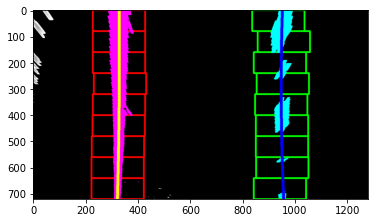

In [170]:
curves = Curves(number_of_windows = 9, margin = 100, minimum_pixels = 50, 
                ym_per_pix = 30 / 720 , xm_per_pix = 3.7 / 700)
binary = cv2.cvtColor(cv2.cvtColor(bird_img, cv2.COLOR_HLS2BGR), cv2.COLOR_BGR2GRAY)
results = curves.fit(binary)
plt.imshow(results["image"])

In [ ]:
def project(self, ground_image, sky_lane, left_fit, right_fit, color = (0, 255, 0)):
    z = np.zeros_like(sky_lane)
    sky_lane = np.dstack((z, z, z))

    kl, kr = left_fit, right_fit
    h = sky_lane.shape[0]
    ys = np.linspace(0, h - 1, h)
    lxs = kl[0] * (ys**2) + kl[1]* ys +  kl[2]
    rxs = kr[0] * (ys**2) + kr[1]* ys +  kr[2]

    pts_left = np.array([np.transpose(np.vstack([lxs, ys]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rxs, ys])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(sky_lane, np.int_(pts), color)

    shape = (sky_lane.shape[1], sky_lane.shape[0])
    ground_lane = cv2.warpPerspective(sky_lane, self.inv_warp_matrix, shape)

    result = cv2.addWeighted(ground_image, 1, ground_lane, 0.3, 0)
    return result

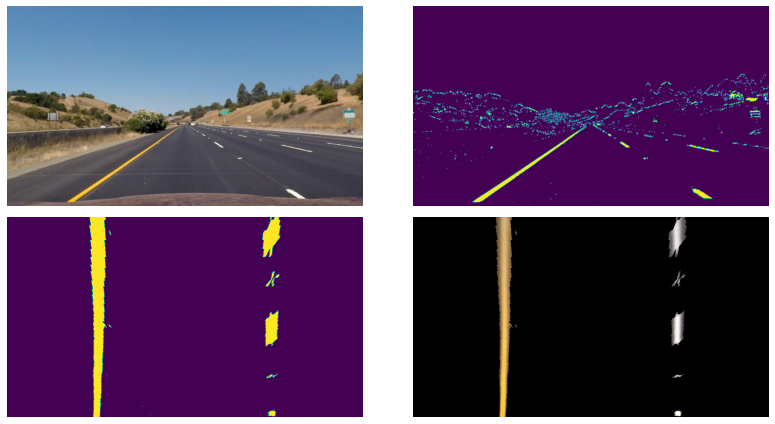

In [216]:
laneFilter = LaneFilter(p)
ground_img = birdsEye.undistort(img)
binary = laneFilter.apply(ground_img)
bird_mask = np.logical_and(birdsEye.sky_view(binary), roi(binary)).astype(np.uint8)
bird_ground_img = birdsEye.sky_view(ground_img)
bird_img = cv2.bitwise_and(bird_ground_img, bird_ground_img, mask=bird_mask)

result = curves.fit(bird_mask)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for ax, f in zip(axes.flatten(), [ground_img, binary, bird_mask, bird_img]):
    ax.imshow(f)
    ax.set_axis_off()
plt.tight_layout()
plt.show()

In [208]:
for k, v in results.items():
    if k != "image":
        print(f"{k}: {v}")

left_radius: 6505.196352103264
right_radius: 3092.3869099243475
real_left_best_fit_curve: [-7.68629863e-05  1.18290375e-03  1.73907495e+00]
real_right_best_fit_curve: [ 1.61695405e-04 -3.95664906e-03  5.03642814e+00]
pixel_left_best_fit_curve: [-2.52459133e-05  9.32469169e-03  3.29014179e+02]
pixel_right_best_fit_curve: [ 5.31094143e-05 -3.11898011e-02  9.52837756e+02]
vehicle_position: 0.001462809461895485
vehicle_position_words: 0.0 m right of center


In [233]:
cv2.line(ground_img, birdsEye.spoints[0], birdsEye.spoints[1], left_color, thickness=5)
cv2.line(ground_img, birdsEye.spoints[2], birdsEye.spoints[3], right_color, thickness=5)

(0, 255)

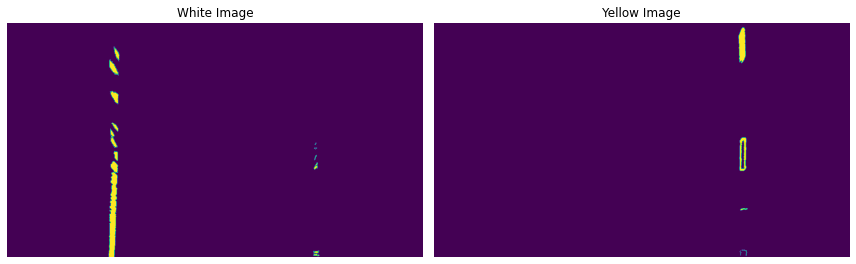

In [236]:
# White-ish areas in image
bird_img_hsl = cv2.cvtColor(bird_img, cv2.COLOR_RGB2HLS)
white_lower = np.array([np.round(  0 / 2), np.round(0.75 * 255), np.round(0.00 * 255)])
white_upper = np.array([np.round(360 / 2), np.round(1.00 * 255), np.round(0.30 * 255)])
white_mask = cv2.inRange(bird_img_hsl, white_lower, white_upper)

# Yellow-ish areas in image
yellow_lower = np.array([np.round( 40 / 2), np.round(0.47 * 255), np.round(0.16 * 255)])
yellow_upper = np.array([np.round( 60 / 2), np.round(1.00 * 255), np.round(1.00 * 255)])
yellow_mask = cv2.inRange(bird_img_hsl, yellow_lower, yellow_upper)
draw(yellow_mask, white_mask, "White Image", "Yellow Image", cmap1=None, cmap2=None)

In [257]:
sky_lane = binary

z = np.zeros_like(sky_lane)
sky_lane = np.dstack((z, z, z))
left_fit, right_fit = results['pixel_left_best_fit_curve'], results['pixel_right_best_fit_curve']
color = (0, 255, 0)
kl, kr = left_fit, right_fit
h = sky_lane.shape[0]
ys = np.linspace(0, h - 1, h)
lxs = kl[0] * (ys**2) + kl[1]* ys +  kl[2]
rxs = kr[0] * (ys**2) + kr[1]* ys +  kr[2]

pts_left = np.array([np.transpose(np.vstack([lxs, ys]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([rxs, ys])))])
pts = np.hstack((pts_left, pts_right))



cv2.fillPoly(sky_lane, np.int_(pts), color)
shape = (sky_lane.shape[1], sky_lane.shape[0])
ground_lane = cv2.warpPerspective(sky_lane, birdsEye.inv_warp_matrix, shape)

cv2.line(ground_img, birdsEye.spoints[0], birdsEye.spoints[1], left_color, thickness=5)
cv2.line(ground_img, birdsEye.spoints[2], birdsEye.spoints[3], right_color, thickness=5)

result = cv2.addWeighted(ground_img, 1, ground_lane, 0.3, 0)

NameError: name 'left_color' is not defined

In [ ]:
matrix = calibration_data['camera_matrix']
distortion_coef = calibration_data['distortion_coefficient']

source_points = [(580, 460), (205, 720), (1110, 720), (703, 460)]
destination_points = [(320, 0), (320, 720), (960, 720), (960, 0)]

p = { 'sat_thresh': 120, 'light_thresh': 40, 'light_thresh_agr': 205,
      'grad_thresh': (0.7, 1.4), 'mag_thresh': 40, 'x_thresh': 20 }

birdsEye = BirdsEye(source_points, destination_points, matrix, distortion_coef)
laneFilter = LaneFilter(p)
curves = Curves(number_of_windows = 9, margin = 100, minimum_pixels = 50,
                ym_per_pix = 30 / 720 , xm_per_pix = 3.7 / 700)

def pipeline(frame):
      
    ground_img = birdsEye.undistort(frame)
    binary = laneFilter.apply(ground_img)
    wb = np.logical_and(birdsEye.sky_view(binary), roi(binary)).astype(np.uint8)
    result = curves.fit(wb)

    ground_img_with_projection = birdsEye.project(ground_img, binary, 
                                                result['pixel_left_best_fit_curve'], 
                                                result['pixel_right_best_fit_curve'])
    return ground_img_with_projection